# NORM-1 ALIGNMENT

In this notebook we provide the steps to do our alignment using amplepy module.
For more references behind the math of the method see the thesis.
Since we are using ampl syntax the data we are going to feed into the model must be in a suitable specific format.

In [1]:
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cplex"],  # modules to install
    license_uuid="your license",  # license to use
)  # instantiate AMPL object and register magics

Licensed to AMPL Community Edition License for <pietro.sanguin99@gmail.com>.


## 1.1 Transforing the embedding matrices into .dat file in order to feed them to the ampl optimizer

After running the script **Embeddings_creation.ipynb** we got three things:

* a matrix containing the source embedding space vectors **X_source_embeddings_p2_0side_2959files.npy**

* a matrix with the target space vectors **Y_target_embeddings_p2_2side_2959files.npy**

* a dictionary of the word2id mapping between the words and the vectors **p2_0side_2959files_&_p2_2side_2959files_word2id.json**

The following names must the same of the script **Embeddings_creation.ipynb**. 

In [2]:
# TO MODIFY IF YOU WANT IF YOU CHANGED THE EMBEDDINGS
SOURCE_PREPROCESSED_TXT = 'p2_0side_2959files_preprocessed.txt'
TARGET_PREPROCESSED_TXT = 'p2_2side_2959files_preprocessed.txt'

SOURCE_PREPROCESSED_TXT = 'p1_0side_50files_preprocessed.txt'
TARGET_PREPROCESSED_TXT = 'p1_2side_50files_preprocessed.txt'


In [3]:
# SHOULD NOT BE MODIFIED
NAME_JSON_FILE = f'{SOURCE_PREPROCESSED_TXT.replace("preprocessed.txt", "")}' +'&_' + f'{TARGET_PREPROCESSED_TXT.replace("_preprocessed.txt", "")}' + "_word2id.json"
X_NAME = f'X_source_embeddings_{SOURCE_PREPROCESSED_TXT.replace("_preprocessed.txt", "")}'+'.npy'
Y_NAME = f'Y_target_embeddings_{TARGET_PREPROCESSED_TXT.replace("_preprocessed.txt", "")}'+'.npy'

W_NAME = 'W_' + (X_NAME.replace('X_', "")).replace('.npy', "") +'_' + Y_NAME.replace('Y_', "")

In [4]:
#DATA PREPROCESSING TO CREATE THE DATASET data.dat
#Metodo per scrivere file.dat per AMPL

import numpy as np

# Create a NumPy matrix
X = np.load(X_NAME)
Y = np.load(Y_NAME)  

#the transpose of X
X = X.T     
Y = Y.T

# Open the .dat file for writing
with open("data.dat", "w") as dat_file:
    #dat_file.write("set Rows;\n")
    #dat_file.write("set Columns;\n")
    #dat_file.write(f"set Rows := 1..{X.shape[0]};\n")  # Define a set of rows with labels 1, 2, 3
    #dat_file.write(f"set Columns := 1..{X.shape[1]};\n")  # Define a set of columns with labels 1, 2, 3
    
    dat_file.write("param x :=\n")

    # Define parameters and populate them with data
    #dat_file.write("param A{Rows, Columns};")

#data;

  
    # Write the matrix data
    for row in range(X.shape[0]):
        for col in range(X.shape[1]):
            dat_file.write(f"\t{row+1} {col+1} {X[row, col]}\n")
            if row == X.shape[0]-1 and col == X.shape[1]-1:
                dat_file.write(";")

    dat_file.write("param y :=\n")

        # Write the matrix data
    for row in range(Y.shape[0]):
        for col in range(Y.shape[1]):
            dat_file.write(f"\t{row+1} {col+1} {Y[row, col]}\n")
            if row == X.shape[0]-1 and col == X.shape[1]-1:
                dat_file.write(";")
    dat_file.write("end;")


In [5]:
ampl.read("decomposition.mod")


In [6]:
ampl.read_data("data.dat")

In [7]:
ampl.option["solver"] = "cplex"

## NOTE BEFORE RUNNING THE AMPL OPTIMIZATION
Check in the files **decomposition.mod** and **decomposition.run** the following

J = K = X.shape[0]??

I = X.shape[1]??

it = X.shape[0]??


In [8]:
X.shape


(300, 4367)

In [10]:
ampl.read("decomposition.run")

CPLEX 22.1.1.0: optimal solution; objective 20.33833643
0 dual simplex iterations (0 in phase I)
18 barrier iterations
CPLEX 22.1.1.0: optimal solution; objective 15.32252306
0 dual simplex iterations (0 in phase I)
17 barrier iterations
CPLEX 22.1.1.0: optimal solution; objective 38.96798895
0 dual simplex iterations (0 in phase I)
18 barrier iterations
CPLEX 22.1.1.0: optimal solution; objective 64.91945699
0 dual simplex iterations (0 in phase I)
17 barrier iterations
CPLEX 22.1.1.0: optimal solution; objective 21.41685387
0 dual simplex iterations (0 in phase I)
18 barrier iterations
CPLEX 22.1.1.0: optimal solution; objective 51.5608526
0 dual simplex iterations (0 in phase I)
18 barrier iterations
CPLEX 22.1.1.0: optimal solution; objective 32.32598345
0 dual simplex iterations (0 in phase I)
17 barrier iterations
CPLEX 22.1.1.0: optimal solution; objective 13.14430381
0 dual simplex iterations (0 in phase I)
17 barrier iterations
CPLEX 22.1.1.0: optimal solution; objective 81.45

In [11]:
W = ampl.get_variable("W").get_values().to_pandas()     

In [12]:
import numpy as np
W_numpy = np.array(W.unstack().values)

In [13]:
#Qui bisogna modificare il nome in modo che venga come vogliamo noi (coè come c'è nel file)
np.save('W.npy', W_numpy)

In [14]:
Y_pred = np.dot(X.T,W_numpy)

In [15]:
Y_pred.shape

(4367, 300)

In [17]:
import json

# Assuming your JSON file is named 'word_index_dict_common_words_left_right_p1.json'
file_path = NAME_JSON_FILE

# Open the JSON file and load it as a dictionary
with open(file_path, 'r') as json_file:
    word_index_dict = json.load(json_file)

In [27]:
word_index_dict.items()

3177

In [19]:
#Funzione per avere i primi vicini di una parola a scelta
word = 'risultati'
src_word2id = word_index_dict
src_id2word = {v: k for k, v in src_word2id.items()}
tgt_word2id = word_index_dict
tgt_id2word = {v: k for k, v in tgt_word2id.items()}
src_emb = X.T
tgt_emb = Y_pred

def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [33]:


#Politic words (present in the dictionary)
src_words =  ['vecchio', 'ragazza', 'ragazzo', 'uomo', 'donna', 'comunista', 'fascista', 'fuoco']
tgt_words = ['vecchio', 'ragazza', 'ragazzo', 'uomo', 'donna', 'comunista', 'fascista', 'fuoco']

#Gender words
#src_words = ['gay', 'diverso', 'fuoco']
#tgt_words = ['gay', 'diverso', 'fuoco']

#Race words
#src_words = ['nero', 'casa', 'fuoco']
#tgt_words = ['nero', 'casa', 'fuoco']





In [35]:
for word in src_words:
    get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5)

Nearest neighbors of "vecchio":
0.0147 - israele
0.0144 - edito
0.0143 - invitando
0.0143 - trattamenti
0.0142 - micciche
Nearest neighbors of "ragazza":
0.1749 - autonomia
0.1743 - esperti
0.1616 - n
0.1601 - cittadina
0.1557 - precisare
Nearest neighbors of "ragazzo":
0.0445 - toscana
0.0420 - viktor
0.0420 - eretico
0.0409 - canta
0.0367 - abbassare
Nearest neighbors of "uomo":
0.0197 - preoccupazione
0.0195 - tedesco
0.0190 - scomparsa
0.0188 - emergenze
0.0188 - varie
Nearest neighbors of "donna":
0.1803 - aiutare
0.1729 - categorie
0.1479 - spot
0.1452 - ateneo
0.1307 - facebook
Nearest neighbors of "comunista":
0.1343 - economista
0.1243 - solamente
0.1180 - canta
0.1154 - ridotta
0.1150 - impegnate
Nearest neighbors of "fascista":
0.2336 - ospite
0.1849 - tocca
0.1735 - finire
0.1730 - penitenziaria
0.1640 - fai
Nearest neighbors of "fuoco":
0.2951 - dichiarazione
0.1388 - torneremo
0.1336 - interessati
0.1306 - tocchera
0.1197 - trasparenza


In [32]:
parole_presenti = []
parole_assenti = []

for parola in src_words:
    if parola in word_index_dict:
        parole_presenti.append(parola)
    else:
        parole_assenti.append(parola)

print("Parole presenti nel dizionario:", parole_presenti)
print("Parole assenti nel dizionario:", parole_assenti)

Parole presenti nel dizionario: ['nero', 'casa', 'fuoco']
Parole assenti nel dizionario: ['indiano', 'africano', 'straniero', 'alieno', 'zingara', 'nigeriano', 'immigrato', 'negro', 'schiavo', 'tribu', 'foglia', 'cane']


Variance explained: 1.00


NameError: name 'uuid' is not defined

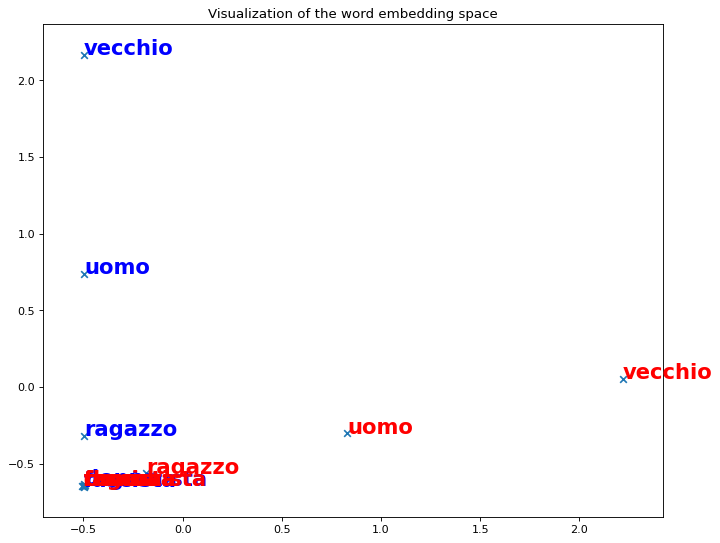

In [34]:
# Visualize multilingual embeddings
from uuid import uuid4

src_embeddings = X.T
tgt_embeddings = Y_pred






from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the word embedding space')
    # Generate a random filename for the PNG
    filename = str(uuid4()) + ".png"

    # Save the plot as a PNG file
    plt.savefig(filename, format='png')

    plt.show()


# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)